# r/MSCS Dataset Analysis
This notebook performs various analyses on the cleaned `r_MSCS_posts_clean.jsonl` and `r_MSCS_comments_clean.jsonl` (or via the post_clean/comments_clean dataframes from the previous notebook).
In this notebook, we focus on:
1. **Sentiment Analysis over time**
2. **Linguistic Markers to identify international applicants**


In [1]:
import os, sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import re
import json
from pathlib import Path

plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_colwidth', None)

# ── Locate notebook directory ────────────────────────────────────────────────
_SENTINEL = 'data/r_MSCS_posts_clean.jsonl'

def _locate_data_dir() -> Path:
    if (Path('.') / _SENTINEL).exists():
        return Path('.').resolve()
    _nb = os.environ.get('JPY_SESSION_NAME', '')
    if _nb:
        _p = Path(_nb).expanduser().resolve().parent
        if (_p / _SENTINEL).exists():
            return _p
    for _d in sys.path:
        if _d and (Path(_d) / _SENTINEL).exists():
            return Path(_d).resolve()
    raise FileNotFoundError(
        f"Cannot find '{_SENTINEL}'.\n"
        "Run clean_mscs_data.ipynb first, then open this notebook "
        "from its own directory (mscs/)."
    )

DATA_DIR = _locate_data_dir()
os.chdir(DATA_DIR)
print(f'Working directory: {DATA_DIR}')

# Load pre-cleaned data produced by clean_mscs_data.ipynb.
# Run that notebook first to generate the output files in data/.
posts    = pd.read_json('data/r_MSCS_posts_clean.jsonl',    lines=True)
comments = pd.read_json('data/r_MSCS_comments_clean.jsonl', lines=True)

# Reconstruct timezone-aware datetime from the unix timestamp column
# (created_dt was dropped before serialisation to avoid tz edge-cases).
posts['created_dt']    = pd.to_datetime(posts['created_utc'],    unit='s', utc=True)
comments['created_dt'] = pd.to_datetime(comments['created_utc'], unit='s', utc=True)

print(f'Posts    : {len(posts):,}')
print(f'Comments : {len(comments):,}')


Loaded 18,372 posts and 131,427 comments from cleaned files.


## 1. Sentiment Analysis Over Time
We will use NLTK's VADER SentimentIntensityAnalyzer to calculate the sentiment of posts and comments over time.

/tmp/ipykernel_36681/941548298.py:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  posts['month'] = posts['created_dt'].dt.to_period('M')


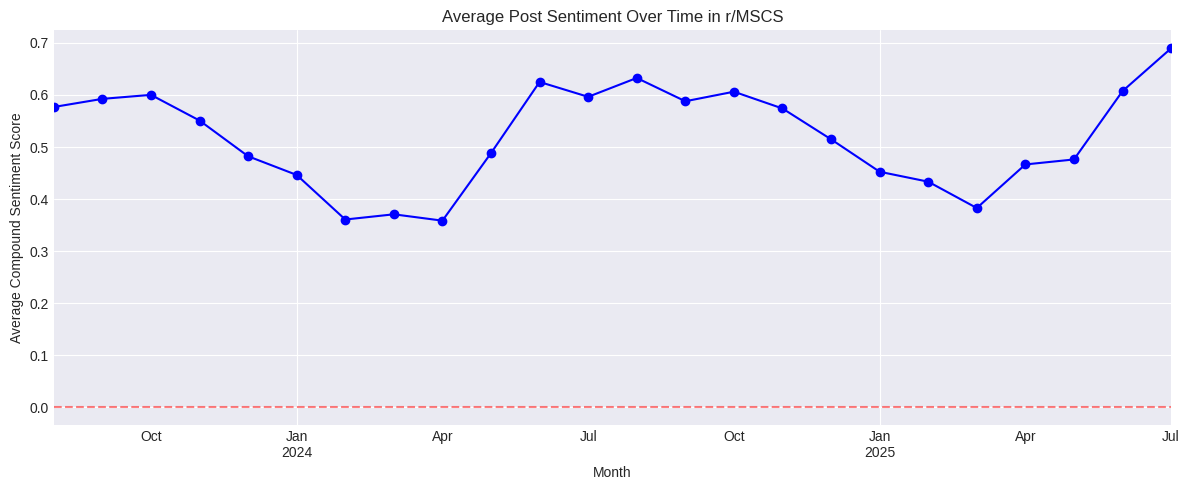

In [2]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon', quiet=True)

sid = SentimentIntensityAnalyzer()

# Calculate sentiment for posts
# Use title + selftext
posts['full_text'] = posts['title'].fillna('') + ". " + posts['selftext'].fillna('')
posts['sentiment_score'] = posts['full_text'].apply(lambda text: sid.polarity_scores(text)['compound'])

# Group by month
posts['month'] = posts['created_dt'].dt.to_period('M')
monthly_sentiment = posts.groupby('month')['sentiment_score'].mean()

plt.figure(figsize=(12, 5))
monthly_sentiment.plot(color='blue', marker='o')
plt.title('Average Post Sentiment Over Time in r/MSCS')
plt.xlabel('Month')
plt.ylabel('Average Compound Sentiment Score')
plt.axhline(0, color='red', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('outputs/sentiment_over_time.png', dpi=150)
plt.show()

## 2. Linguistic Markers (Identifying User Origins/Demographics)
The MSCS subreddit has a large demographic of international students, particularly from India. 
We can look for specific linguistic markers such as:
* **"Tier 1" / "Tier 2" / "Tier 3"** - commonly used to describe undergraduate colleges in India.
* **"CGPA" or "GPA: X/10"** - vs the standard US 4.0 scale.
* **"B.Tech" or "BE"** - Bachelor of Technology/Engineering.
* **"Lakhs" / "Crores" or "INR"** - Indian currency units.

Found 4017 posts (21.9%) with linguistic markers indicating international/Indian applicants.
Average sentiment (International/Indian): 0.698
Average sentiment (Other/Unidentified): 0.411


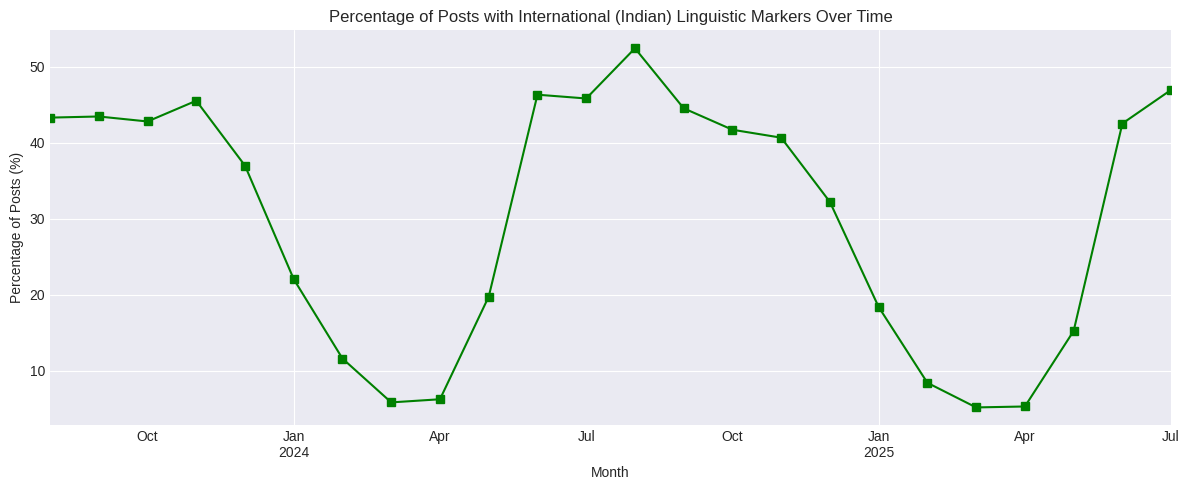

In [3]:
# Define explicit regex patterns for markers
tier_pattern = re.compile(r'tier\s*[1-3]', re.IGNORECASE)
cgpa_pattern = re.compile(r'cgpa|\b\d\.\d+\s*/\s*10\b', re.IGNORECASE)

# B.Tech  — unchanged, \b on both sides is fine.
# B.E.    — the original r'b\.?e\.?\b' had a critical bug: making the first dot optional
#            caused it to match the common English word "be" (and "Be", "BE") since
#            b + (no dot) + e satisfies b\.?e, and \b fires at any word boundary.
#            Fix: require the dot between B and E (first dot is now mandatory: b\.e).
#            The trailing dot stays optional to accept both "B.E" and "B.E."
#            "be" (no dot) → no longer matches. ✓
degree_pattern = re.compile(r'\bb\.?tech\b|\bb\.e\.?', re.IGNORECASE)

currency_pattern = re.compile(r'\blakhs?\b|\blacs?\b|\bcrores?\b|\binr\b', re.IGNORECASE)

def has_indian_markers(text):
    if not isinstance(text, str): return False
    return bool(tier_pattern.search(text) or cgpa_pattern.search(text) or degree_pattern.search(text) or currency_pattern.search(text))

posts['is_international_indian'] = posts['full_text'].apply(has_indian_markers)

intl_count = posts['is_international_indian'].sum()
total_count = len(posts)
print(f"Found {intl_count} posts ({intl_count/total_count*100:.1f}%) with linguistic markers indicating international/Indian applicants.")

# Compare Sentiment: International vs General
avg_sentiment_intl = posts[posts['is_international_indian']]['sentiment_score'].mean()
avg_sentiment_other = posts[~posts['is_international_indian']]['sentiment_score'].mean()

print(f"Average sentiment (International/Indian): {avg_sentiment_intl:.3f}")
print(f"Average sentiment (Other/Unidentified): {avg_sentiment_other:.3f}")

# Plotting the proportion over time
monthly_intl = posts.groupby('month')['is_international_indian'].mean() * 100

plt.figure(figsize=(12, 5))
monthly_intl.plot(color='green', marker='s')
plt.title('Percentage of Posts with International (Indian) Linguistic Markers Over Time')
plt.xlabel('Month')
plt.ylabel('Percentage of Posts (%)')
plt.tight_layout()
plt.savefig('outputs/intl_markers_over_time.png', dpi=150)
plt.show()

## 3. Bias and Demographic Skew Analysis
To address potential biases (like self-selection or platform demographic skew), we can look at two factors:
1. **Posting Hours**: Plotting the hour of the day posts are created. If the majority of posts occur during standard Indian Standard Time (IST) working hours rather than EST/PST, it confirms geographic skew.
2. **Admit vs Reject Bias (Self-Selection)**: People are generally more likely to post their 'Acceptances' than 'Rejections'. We can do a quick keyword tally to see if the subreddit portrays an unrealistically high acceptance rate.

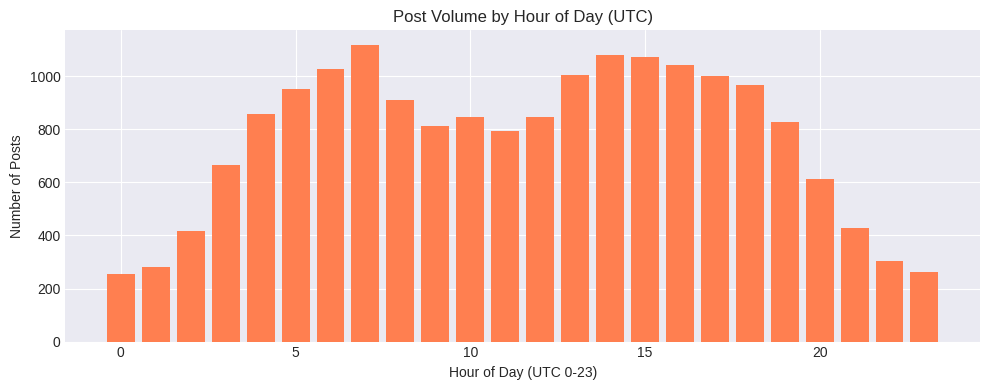

Posts mentioning Admits: 6257
Posts mentioning Rejects: 1569
Ratio (Admit:Reject) = 3.99:1
Conclusion: Strong self-selection bias. Users are highly biased toward posting positive outcomes.


In [4]:
# 1. Posting Hours (UTC)
posts['hour_utc'] = posts['created_dt'].dt.hour
hour_counts = posts['hour_utc'].value_counts().sort_index()

plt.figure(figsize=(10, 4))
plt.bar(hour_counts.index, hour_counts.values, color='coral')
plt.title('Post Volume by Hour of Day (UTC)')
plt.xlabel('Hour of Day (UTC 0-23)')
plt.ylabel('Number of Posts')
# Note: IST is UTC+5:30. A spike at 4-10 UTC corresponds exactly to 9:30 AM - 3:30 PM IST.
plt.tight_layout()
plt.savefig('outputs/posting_hours_skew.png', dpi=150)
plt.show()

# 2. Admit vs Reject Self-Selection Bias
admit_pattern = re.compile(r'\badmit|\baccepted|\boffer|\bgot in\b', re.IGNORECASE)
reject_pattern = re.compile(r'\breject|\bdenied|\bdinged', re.IGNORECASE)

posts['mentions_admit'] = posts['full_text'].apply(lambda x: bool(admit_pattern.search(x)))
posts['mentions_reject'] = posts['full_text'].apply(lambda x: bool(reject_pattern.search(x)))

admit_count = posts['mentions_admit'].sum()
reject_count = posts['mentions_reject'].sum()

print(f"Posts mentioning Admits: {admit_count}")
print(f"Posts mentioning Rejects: {reject_count}")
print(f"Ratio (Admit:Reject) = {admit_count/max(1, reject_count):.2f}:1")
print("Conclusion: Strong self-selection bias. Users are highly biased toward posting positive outcomes.")


## 4. Bot and Noise Impact (Challenges Faced)
How much of the raw data was actually noise? This visualization will show exactly how much data was purged due to deletion/removal or bot-authorship, which is a great talking point for the 'Challenges' section.

Raw posts       : 18,799
Deleted/removed : 390
Bot authors     : 37
Kept (clean)    : 18,372


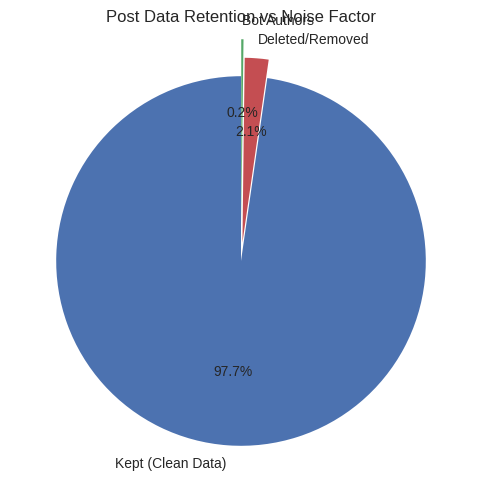

In [5]:
# Load per-stage counts from the stats file saved by clean_mscs_data.ipynb.
# This replaces the old hardcoded numbers and removes the need to re-run
# bot detection logic inside this notebook.
with open('data/r_MSCS_cleaning_stats.json') as f:
    _ps = json.load(f)['posts']

n_raw     = _ps['n_raw']
n_deleted = _ps['n_deleted']
n_bots    = _ps['n_bots']
n_kept    = _ps['n_clean']

print(f"Raw posts       : {n_raw:,}")
print(f"Deleted/removed : {n_deleted:,}")
print(f"Bot authors     : {n_bots:,}")
print(f"Kept (clean)    : {n_kept:,}")

labels  = ['Kept (Clean Data)', 'Deleted/Removed', 'Bot Authors']
sizes   = [n_kept, n_deleted, n_bots]
explode = (0, 0.1, 0.2)

plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=['#4C72B0', '#C44E52', '#55A868'])
plt.title('Post Data Retention vs Noise Factor')
plt.savefig('outputs/noise_impact_pie.png', dpi=150)
plt.show()

## 5. Metadata and Engagement Distribution
Reddit data is unique because of community voting and comment threads. Let's look at the distribution of engagement (Comments and Scores). The 'long tail' is very characteristic of social media data.

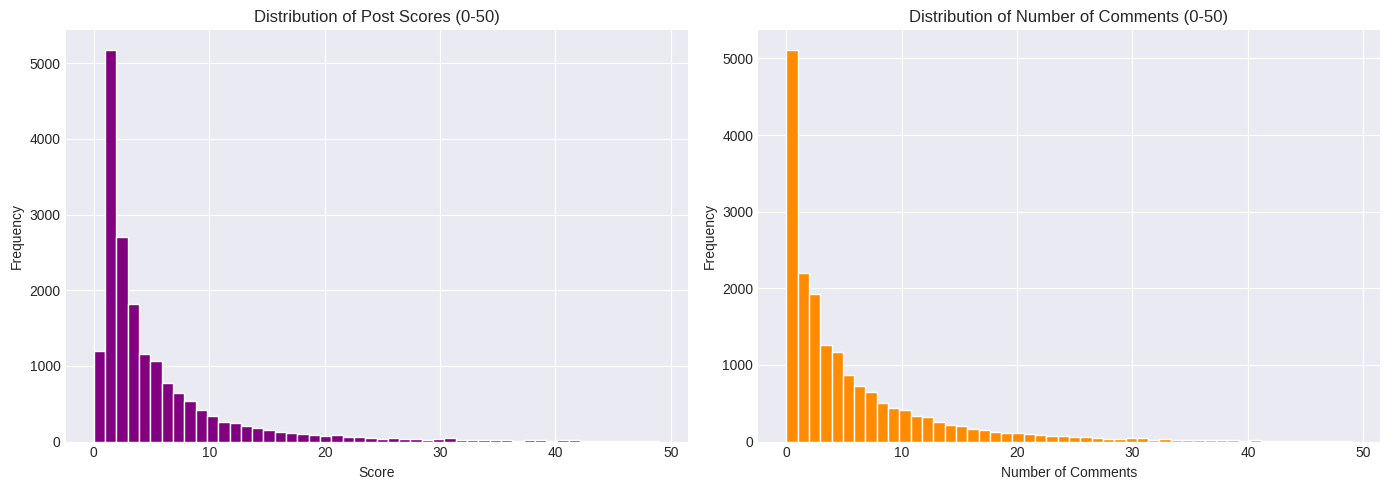

Median Score: 3.0
Median Comments: 2.0


In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot Post Scores (Zoomed in to 0-50 to avoid massive outliers ruining the view)
axes[0].hist(posts[posts['score'] < 50]['score'], bins=50, color='purple', edgecolor='white')
axes[0].set_title('Distribution of Post Scores (0-50)')
axes[0].set_xlabel('Score')
axes[0].set_ylabel('Frequency')

# Plot Number of Comments (Zoomed in 0-50)
axes[1].hist(posts[posts['num_comments'] < 50]['num_comments'], bins=50, color='darkorange', edgecolor='white')
axes[1].set_title('Distribution of Number of Comments (0-50)')
axes[1].set_xlabel('Number of Comments')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('outputs/engagement_long_tail.png', dpi=150)
plt.show()

print(f"Median Score: {posts['score'].median()}")
print(f"Median Comments: {posts['num_comments'].median()}")


## 6. Real-World Events & Temporal Correlation

The subreddit's activity is tightly coupled to two external clocks: the **CS admissions calendar** and the **tech industry/policy environment**. This section overlays known events on the time series to make that coupling visible.

### 6a. Annotated Post Volume & Sentiment

Three event categories are colour-coded:

| Category | Colour | Examples |
|---|---|---|
| **Cycle** (admissions milestones) | Blue | App deadlines (Dec), decisions (Feb–Mar), enrol deadline (Apr 15) |
| **Industry** (tech market) | Red | Jan 2024 tech layoff wave |
| **Policy** (immigration) | Orange | H-1B lottery (Apr), 2024 US election (Nov), new admin policies (Jan 2025) |

Expected patterns to look for:
- Post **volume spikes** around Dec (deadlines) and Feb–Apr (decisions)
- **Sentiment dips** around decision season — anxiety over rejections
- **Sentiment drop** around election / new admin policy announcements — international-student concern

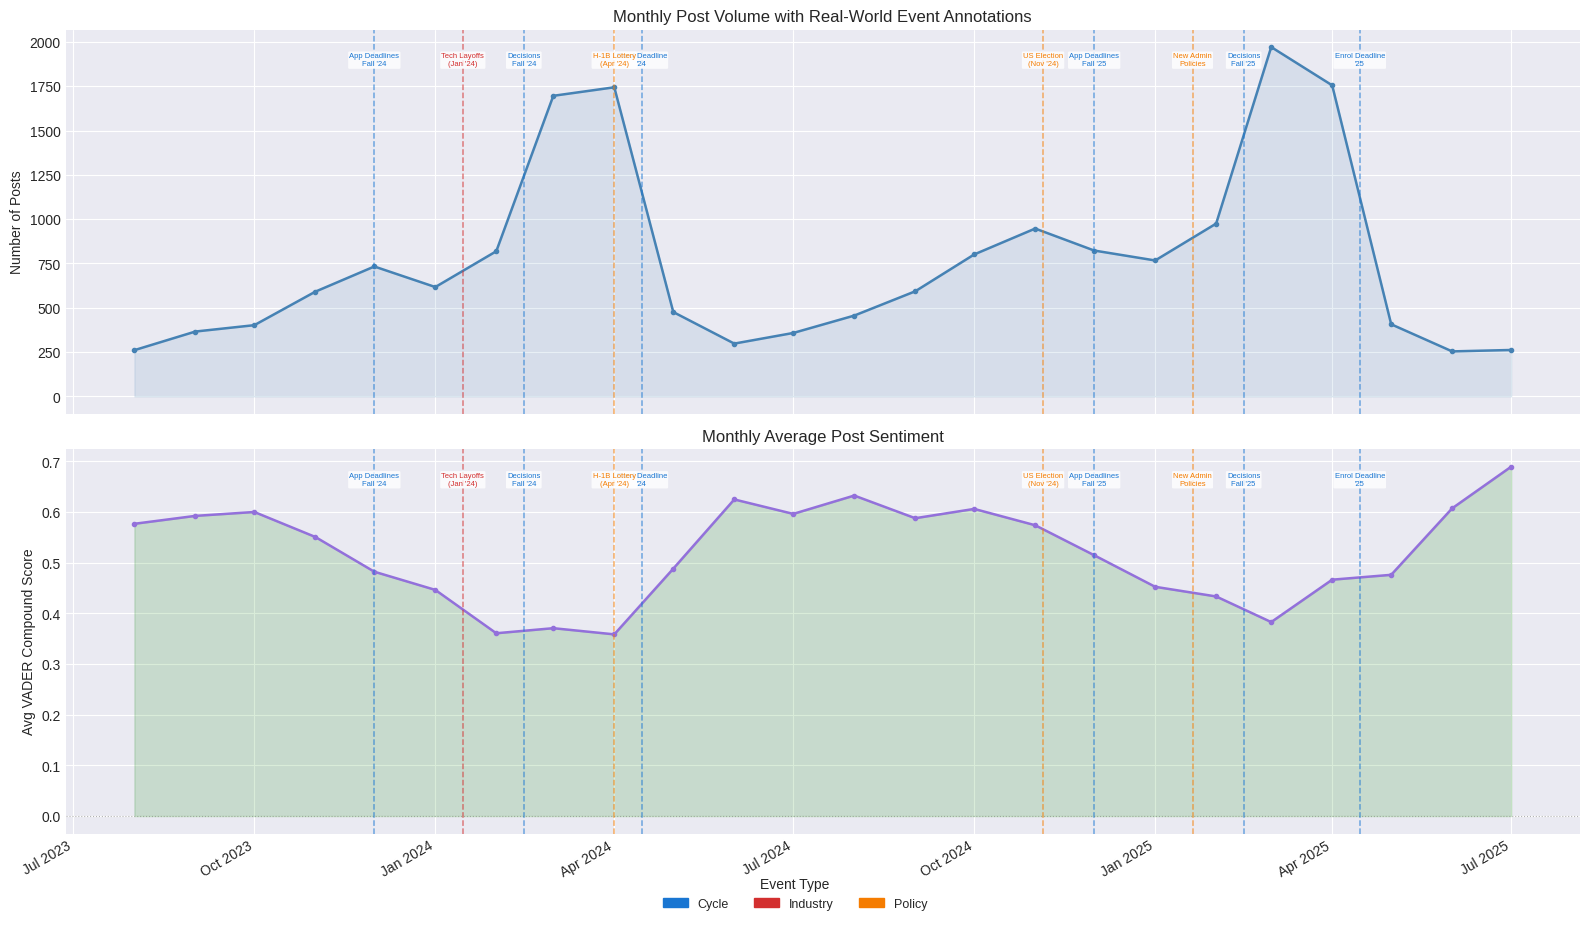

In [7]:
# ── 6a. Annotated Post Volume & Sentiment ────────────────────────────────────
# Real-world events annotated as vertical dashed lines.
# Three categories (colour-coded):
#   cycle    — admissions calendar milestones (deadlines, decisions, enrolment)
#   industry — tech layoff waves
#   policy   — immigration / political events (H-1B lottery, US election, new admin)

EVENTS = [
    # ── Admissions cycle — Fall 2024 applications ──
    ('2023-12-01', "App Deadlines\nFall '24",  'cycle'),
    ('2024-02-15', "Decisions\nFall '24",       'cycle'),
    ('2024-04-15', "Enrol Deadline\n'24",        'cycle'),
    # ── Admissions cycle — Fall 2025 applications ──
    ('2024-12-01', "App Deadlines\nFall '25",  'cycle'),
    ('2025-02-15', "Decisions\nFall '25",       'cycle'),
    ('2025-04-15', "Enrol Deadline\n'25",        'cycle'),
    # ── Tech industry ──
    ('2024-01-15', "Tech Layoffs\n(Jan '24)",   'industry'),
    # ── Policy / immigration ──
    ('2024-04-01', "H-1B Lottery\n(Apr '24)",   'policy'),
    ('2024-11-05', "US Election\n(Nov '24)",     'policy'),
    ('2025-01-20', "New Admin\nPolicies",        'policy'),
]

EVENT_COLORS = {'cycle': '#1976D2', 'industry': '#D32F2F', 'policy': '#F57C00'}


def annotate_events(ax, events, y_frac=0.94):
    """Draw labelled vertical lines for each event on *ax*."""
    ylim = ax.get_ylim()
    yspan = ylim[1] - ylim[0]
    for date_str, label, cat in events:
        ts = pd.Timestamp(date_str)
        ax.axvline(ts, color=EVENT_COLORS[cat], lw=1.1, ls='--', alpha=0.6)
        ax.text(
            ts, ylim[0] + yspan * y_frac, label,
            color=EVENT_COLORS[cat], fontsize=5.5, ha='center', va='top',
            bbox=dict(boxstyle='round,pad=0.15', fc='white', ec='none', alpha=0.8),
        )


# Convert Period index → Timestamp for matplotlib date formatting
vol_ts  = posts.groupby('month').size().copy()
vol_ts.index = vol_ts.index.to_timestamp()

sent_ts = monthly_sentiment.copy()
sent_ts.index = sent_ts.index.to_timestamp()

fig, axes = plt.subplots(2, 1, figsize=(16, 9), sharex=True)

# ── Top panel: post volume ────────────────────────────────────────────────────
axes[0].plot(vol_ts.index, vol_ts.values,
             color='steelblue', marker='o', ms=3, lw=1.8)
axes[0].fill_between(vol_ts.index, vol_ts.values, alpha=0.12, color='steelblue')
axes[0].set_ylabel('Number of Posts')
axes[0].set_title('Monthly Post Volume with Real-World Event Annotations')
annotate_events(axes[0], EVENTS)

# ── Bottom panel: sentiment ───────────────────────────────────────────────────
axes[1].plot(sent_ts.index, sent_ts.values,
             color='mediumpurple', marker='o', ms=3, lw=1.8)
axes[1].axhline(0, color='gray', ls=':', lw=0.8, alpha=0.6)
axes[1].fill_between(sent_ts.index, sent_ts.values,
                     where=sent_ts.values >= 0, alpha=0.15, color='green')
axes[1].fill_between(sent_ts.index, sent_ts.values,
                     where=sent_ts.values < 0,  alpha=0.15, color='red')
axes[1].set_ylabel('Avg VADER Compound Score')
axes[1].set_title('Monthly Average Post Sentiment')
annotate_events(axes[1], EVENTS)

axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=30, ha='right')

# Shared event-type legend
legend_patches = [mpatches.Patch(color=v, label=k.title()) for k, v in EVENT_COLORS.items()]
fig.legend(handles=legend_patches, title='Event Type',
           loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.03), fontsize=9)

plt.tight_layout()
plt.savefig('outputs/events_overlay.png', dpi=150, bbox_inches='tight')
plt.show()

### 6b. Keyword Group Prevalence Over Time

Five semantic keyword groups are tracked monthly to surface **what** is driving the correlation:

| Group | Example terms |
|---|---|
| Applications | SOP, LOR, deadline, apply |
| Decisions | accepted, rejected, waitlist, ding, interview |
| Visa & Work Auth | H-1B, OPT, STEM OPT, visa, sponsorship |
| Job Market | layoff, laid off, hiring freeze |
| Anxiety | worried, anxious, stressed, panicking |

When these are overlaid with the event lines, you can see that topic surges are *caused by* real events, not random noise — e.g. "Decisions" spikes sharply in Feb–Mar, "Applications" peaks Nov–Dec, and "Visa & Work Auth" rises after the H-1B lottery and the November 2024 election.

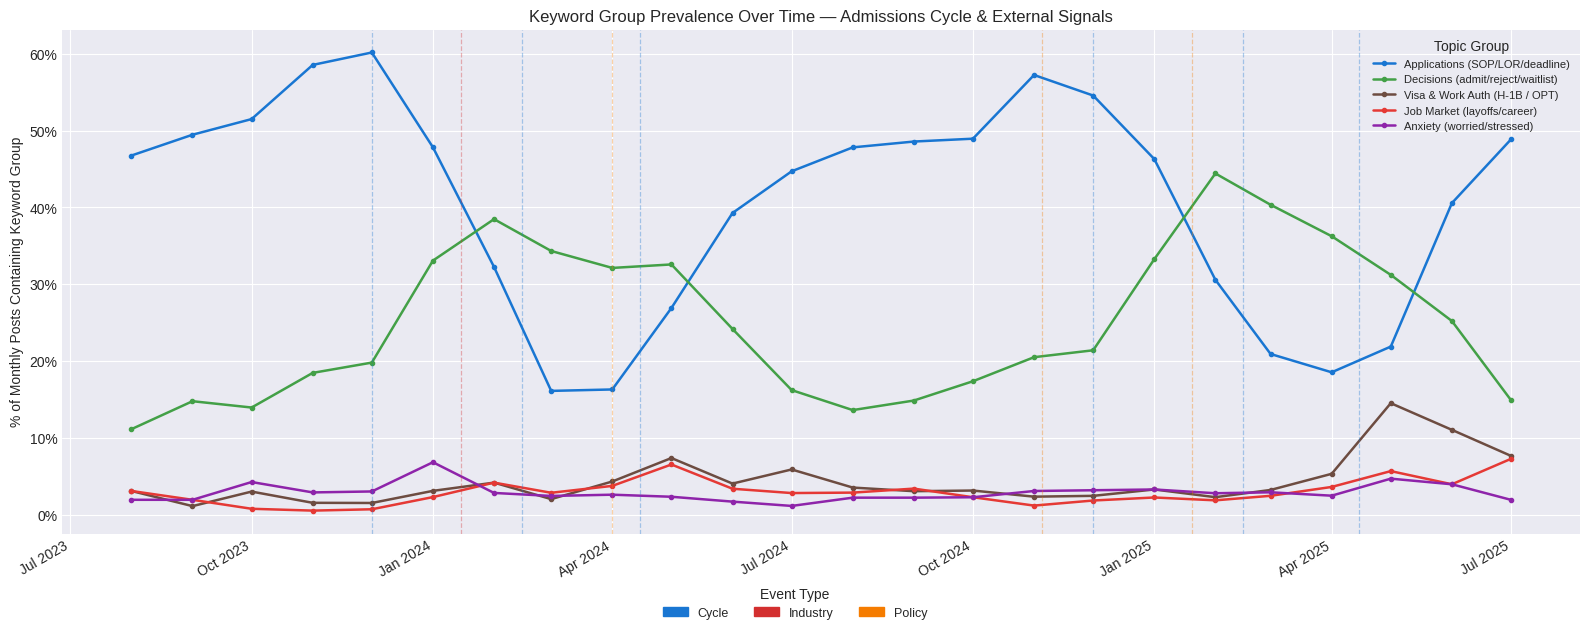

In [8]:
# ── 6b. Keyword Group Prevalence Over Time ───────────────────────────────────
# Five semantic groups track *what* the subreddit is discussing each month.
# When overlaid with the event annotations you can see topic surges that
# directly follow real-world triggers (e.g. "Decisions" spiking Feb–Mar,
# "Visa/Work Auth" spiking after the H-1B lottery and the 2024 US election).

KEYWORD_GROUPS = {
    'Applications\n(SOP/LOR/deadline)': re.compile(
        r'\bSOP\b|\bstatement of purpose\b|\bLOR\b|\bdeadline\b'
        r'|\bapply\b|\bapplied\b|\bapplication\b',
        re.IGNORECASE,
    ),
    'Decisions\n(admit/reject/waitlist)': re.compile(
        r'\baccepted\b|\brejected\b|\bwaitlist\b|\bding(ed)?\b'
        r'|\badmit(ted)?\b|\bdecision\b|\binterview\b',
        re.IGNORECASE,
    ),
    'Visa & Work Auth\n(H-1B / OPT)': re.compile(
        r'\bH.?1.?B\b|\bOPT\b|\bSTEM\s*OPT\b|\bvisa\b'
        r'|\bwork\s*auth\b|\bsponsorship\b|\bimmigration\b',
        re.IGNORECASE,
    ),
    'Job Market\n(layoffs/career)': re.compile(
        r'\blayoff\b|\blaid\s*off\b|\bjob\s*market\b'
        r'|\bhiring\s*freeze\b|\bjob\s*offer\b|\btech\s*job\b',
        re.IGNORECASE,
    ),
    'Anxiety\n(worried/stressed)': re.compile(
        r'\bworried\b|\banxious\b|\bstress(ed)?\b|\bnervous\b'
        r'|\bhopeless\b|\bscared\b|\bpanic\b',
        re.IGNORECASE,
    ),
}

for name, pat in KEYWORD_GROUPS.items():
    posts[f'_kw_{name}'] = posts['full_text'].apply(
        lambda t: bool(pat.search(t)) if isinstance(t, str) else False
    )

kw_cols = [f'_kw_{n}' for n in KEYWORD_GROUPS]
monthly_kw = posts.groupby('month')[kw_cols].mean() * 100
monthly_kw.index = monthly_kw.index.to_timestamp()
monthly_kw.columns = list(KEYWORD_GROUPS.keys())

KW_COLORS = ['#1976D2', '#43A047', '#6D4C41', '#E53935', '#8E24AA']

fig, ax = plt.subplots(figsize=(16, 6))
for col, color in zip(monthly_kw.columns, KW_COLORS):
    ax.plot(monthly_kw.index, monthly_kw[col],
            label=col.replace('\n', ' '), color=color, marker='o', ms=3, lw=1.8)

# Light event annotations (lower alpha so keyword lines stay readable)
for d, lbl, cat in EVENTS:
    ax.axvline(pd.Timestamp(d), color=EVENT_COLORS[cat], lw=0.9, ls='--', alpha=0.35)

ax.set_ylabel('% of Monthly Posts Containing Keyword Group')
ax.set_title('Keyword Group Prevalence Over Time — Admissions Cycle & External Signals')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=30, ha='right')
ax.legend(loc='upper right', fontsize=8, title='Topic Group', framealpha=0.9)

# Re-add the event-type legend below the chart
leg2 = [mpatches.Patch(color=EVENT_COLORS[k], label=k.title()) for k in EVENT_COLORS]
fig.legend(handles=leg2, title='Event Type', loc='lower center',
           ncol=3, bbox_to_anchor=(0.5, -0.06), fontsize=9)

plt.tight_layout()
plt.savefig('outputs/keyword_trends.png', dpi=150, bbox_inches='tight')
plt.show()